# Introduction

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations.

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.

Here are a few questions that this project has sought to answer:

- What is the distribution of conservation status for species?
- Which species are the most endangered?
- Which animal is most prevalent and what is their distribution amongst parks?
- Are the differences between species and their conservation status significant?

**Data sources:**

Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).

Note: The data for this project is *inspired* by real data, but is mostly fictional.

# Data exploration

In [766]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

In [767]:
species = pd.read_csv('species_info.csv')
observations = pd.read_csv('observations.csv')

In [768]:
species.head(5)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [769]:
print(species.shape)

(5824, 4)


In [770]:
observations.head(5)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Species

In [771]:
species.head(2)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN


In [772]:
print('unique conservation statuses:', species.conservation_status.unique())

unique conservation statuses: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [773]:
print('number of nan values: {}'.format(species.conservation_status.isna().sum()))
print('number of values: {}'.format(species.shape[0]))

number of nan values: 5633
number of values: 5824


### Filling NaN values

In [774]:
species.conservation_status.fillna('No concern', inplace=True)

In [775]:
print(species.conservation_status.value_counts())

No concern            5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: conservation_status, dtype: int64


### Duplicates analysis

In [776]:
print('number of unique species:', species.scientific_name.nunique())

print('total number of species:', species.shape[0])

print('data contains duplicate scientific names!')

number of unique species: 5541
total number of species: 5824
data contains duplicate scientific names!


In [777]:
dupl_sc_names = species[species.scientific_name.duplicated(keep = False) == True].sort_values('scientific_name')

In [778]:
dupl_sc_names

,category,scientific_name,common_names,conservation_status
5553,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass",No concern
2132,Vascular Plant,Agrostis capillaris,Rhode Island Bent,No concern
2134,Vascular Plant,Agrostis gigantea,Redtop,No concern
5554,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass",No concern
4178,Vascular Plant,Agrostis mertensii,"Arctic Bentgrass, Northern Bentgrass",No concern
...,...,...,...,...
5643,Vascular Plant,Vulpia myuros,"Foxtail Fescue, Rattail Fescue, Rat-Tail Fescu...",No concern
2331,Vascular Plant,Vulpia octoflora,Annual Fescue,No concern
4290,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",No concern
3347,Vascular Plant,Zizia aptera,"Heartleaf Alexanders, Heart-Leaf Alexanders, M...",No concern


In [779]:
# we should check whether there are duplicates with different conserwation status, 
#since this might be a problem
for name in dupl_sc_names.scientific_name.unique():
    if dupl_sc_names[dupl_sc_names.scientific_name == name].conservation_status.nunique() > 1:
        print(dupl_sc_names[dupl_sc_names.scientific_name == name])
        print('\n')

     category scientific_name     common_names conservation_status
8      Mammal     Canis lupus        Gray Wolf          Endangered
3020   Mammal     Canis lupus  Gray Wolf, Wolf         In Recovery
4448   Mammal     Canis lupus  Gray Wolf, Wolf          Endangered


     category      scientific_name   common_names conservation_status
3283     Fish  Oncorhynchus mykiss  Rainbow Trout          Threatened
560      Fish  Oncorhynchus mykiss  Rainbow Trout          No concern




We can see, that there are 2 species with such discrepancy. 

In case of Canis lupus we  see, that row 3020 must be a mistake, since other rows' conservation statuses are same.

In case of Oncorhynchus mykiss we cannot be sure, that's why we'd better delete this row, as well as other duplicate rows.

In [780]:
species.drop([8, 3020, 3283, 560], inplace = True)
species = species.reset_index(drop=True)

We cannot remove duplicate rows, since they have different common names, so we'll have to combine common_names at first

In [781]:
dupl_sc_names = species[species.scientific_name.duplicated(keep = False) == True]\
.sort_values('scientific_name') # once again after reset_index

In [782]:
dupl_sc_names.head(2)

,category,scientific_name,common_names,conservation_status
5549,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass",No concern
2130,Vascular Plant,Agrostis capillaris,Rhode Island Bent,No concern


In [783]:
dfs = []
for name in dupl_sc_names.scientific_name.unique():
    tmp = dupl_sc_names[dupl_sc_names.scientific_name == name].copy()
    final = ','.join(tmp.common_names.tolist())
    tmp.common_names = tmp.common_names.apply(lambda x: final)
    dfs.append(tmp)

In [784]:
duplicated = pd.concat(dfs)

In [785]:
dupl_sc_names.head(5) # this dataframe contains ALL scientific_name duplicates 

,category,scientific_name,common_names,conservation_status
5549,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass",No concern
2130,Vascular Plant,Agrostis capillaris,Rhode Island Bent,No concern
5550,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass",No concern
2132,Vascular Plant,Agrostis gigantea,Redtop,No concern
4174,Vascular Plant,Agrostis mertensii,"Arctic Bentgrass, Northern Bentgrass",No concern


In [786]:
duplicated.head(5) # this dataframe contains scientific_name 
                    # with combined common_names for each species

,category,scientific_name,common_names,conservation_status
5549,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass,Rhode Island...",No concern
2130,Vascular Plant,Agrostis capillaris,"Colonial Bent, Colonial Bentgrass,Rhode Island...",No concern
5550,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass,Redtop",No concern
2132,Vascular Plant,Agrostis gigantea,"Black Bent, Redtop, Water Bentgrass,Redtop",No concern
4174,Vascular Plant,Agrostis mertensii,"Arctic Bentgrass, Northern Bentgrass,Northern ...",No concern


In [787]:
duplicated.drop_duplicates(inplace = True) # only non-duplicated indexes are left now 

In [788]:
species.drop(list(dupl_sc_names.index), inplace=True) 
#  ALL indexes that have duplicates are dropped, 
# so now data contains only species that have never had duplicates

In [789]:
species = pd.concat([species, duplicated]) # species that used to be duplicated are added 

In [790]:
species.scientific_name.duplicated().value_counts()

False    5540
Name: scientific_name, dtype: int64

Thus, we have dropped duplicated scientific names, but we keep all common_names for each species.

Also one species of fish was dropped because of its conservation_status uncertainty.

In [791]:
species

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No concern
1,Mammal,Bos bison,"American Bison, Bison",No concern
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No concern
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No concern
7,Mammal,Canis latrans,Coyote,Species of Concern
...,...,...,...,...
3228,Bird,Vireo solitarius,"Blue-Headed Vireo,Blue-Headed Vireo, Solitary ...",No concern
2327,Vascular Plant,Vulpia bromoides,"Fescue,Brome Fescue, Brome Six-Weeks Grass, De...",No concern
2328,Vascular Plant,Vulpia myuros,"Rattail Fescue,Foxtail Fescue, Rattail Fescue,...",No concern
4286,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",No concern


### Categories analysis

In [792]:
print('unique categories: ', list(species.groupby('category').groups.keys()))

unique categories:  ['Amphibian', 'Bird', 'Fish', 'Mammal', 'Nonvascular Plant', 'Reptile', 'Vascular Plant']


In [793]:
print('number of unique categories: {}'.format(
len(list(species.groupby('category').groups.keys()))))

number of unique categories: 7


In [794]:
species.groupby('category').size()

category
Amphibian              79
Bird                  488
Fish                  124
Mammal                176
Nonvascular Plant     333
Reptile                78
Vascular Plant       4262
dtype: int64

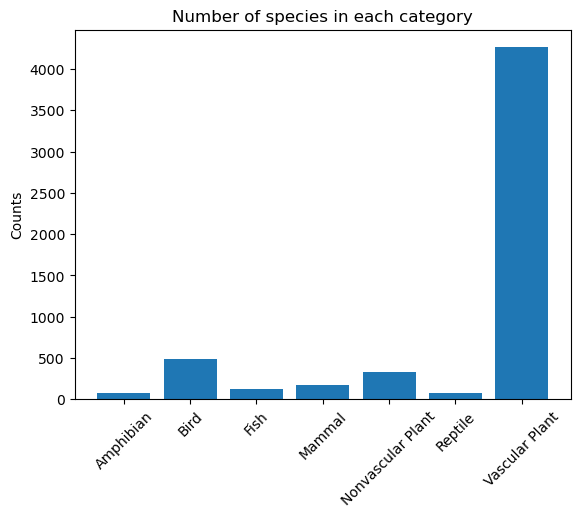

In [795]:
ax = plt.subplot()
plt.bar(range(len(species.groupby('category').size())), species.groupby('category').size())
ax.set_xticks(range(len(list(species.groupby('category').groups.keys()))))
ax.set_xticklabels(list(species.groupby('category').groups.keys()))
plt.xticks(rotation = 45)
plt.title('Number of species in each category')
plt.ylabel('Counts')
plt.show()

## Observations

In [796]:
observations.head(5)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [797]:
observations.shape[0]

23296

In [798]:
print(observations.isna().value_counts()) # no NaN values

scientific_name  park_name  observations
False            False      False           23296
dtype: int64


In [799]:
observations[observations.duplicated(subset=['scientific_name', 'park_name'], keep=False)].sort_values('scientific_name')

,scientific_name,park_name,observations
792,Agrostis capillaris,Great Smoky Mountains National Park,84
7750,Agrostis capillaris,Yosemite National Park,182
17735,Agrostis capillaris,Yosemite National Park,140
4864,Agrostis capillaris,Bryce National Park,105
6166,Agrostis capillaris,Yellowstone National Park,241
...,...,...,...
17162,Zizia aptera,Yellowstone National Park,269
13904,Zizia aptera,Bryce National Park,112
8445,Zizia aptera,Yosemite National Park,123
7753,Zizia aptera,Great Smoky Mountains National Park,105


We see that there are several different observations of the same species in the same parks. Thus, we assume that these observations should be summed.  

In [800]:
observations = observations.groupby(['scientific_name', 'park_name']).sum().reset_index()
observations.head(5)

,scientific_name,park_name,observations
0,Abies bifolia,Bryce National Park,109
1,Abies bifolia,Great Smoky Mountains National Park,72
2,Abies bifolia,Yellowstone National Park,215
3,Abies bifolia,Yosemite National Park,136
4,Abies concolor,Bryce National Park,83


In [801]:
print('number of unique parks: ', observations.park_name.nunique())
print('unique parks: ', observations.park_name.unique())

number of unique parks:  4
unique parks:  ['Bryce National Park' 'Great Smoky Mountains National Park'
 'Yellowstone National Park' 'Yosemite National Park']


In [802]:
obs_parks = observations.groupby('park_name').sum().reset_index()
obs_parks

,park_name,observations
0,Bryce National Park,576025
1,Great Smoky Mountains National Park,431820
2,Yellowstone National Park,1443562
3,Yosemite National Park,863332


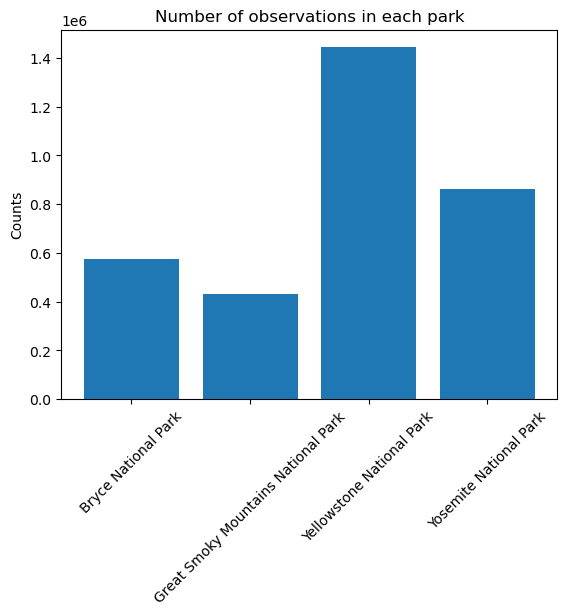

In [803]:
ax = plt.subplot()
plt.bar(range(len(obs_parks)), obs_parks.observations)
ax.set_xticks(range(len(obs_parks)))
ax.set_xticklabels(list(obs_parks.park_name))
plt.xticks(rotation = 45)
plt.title('Number of observations in each park')
plt.ylabel('Counts')
plt.show()

# Data analysis
## Conservation status investigation

In [804]:
species.head(2)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No concern
1,Mammal,Bos bison,"American Bison, Bison",No concern


Let's focus on protected species

In [805]:
cons_category = species[species.conservation_status != 'No concern'].groupby(['conservation_status', 'category']).count()['scientific_name'].reset_index()

In [806]:
cons_category.rename(columns={'scientific_name': "count"}, inplace=True)

In [807]:
cons_category

,conservation_status,category,count
0,Endangered,Amphibian,1
1,Endangered,Bird,4
2,Endangered,Fish,3
3,Endangered,Mammal,6
4,Endangered,Vascular Plant,1
5,In Recovery,Bird,3
6,Species of Concern,Amphibian,4
7,Species of Concern,Bird,68
8,Species of Concern,Fish,4
9,Species of Concern,Mammal,22


In [808]:
cons_category_pivot1 = cons_category.pivot(index='category', columns='conservation_status', values='count')

cons_category_pivot2 = cons_category.pivot(index='conservation_status', columns='category', values='count')

In [809]:
cons_category_pivot1

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,1.0,NaN,4.0,2.0
Bird,4.0,3.0,68.0,NaN
Fish,3.0,NaN,4.0,3.0
Mammal,6.0,NaN,22.0,2.0
Nonvascular Plant,NaN,NaN,5.0,NaN
Reptile,NaN,NaN,5.0,NaN
Vascular Plant,1.0,NaN,43.0,2.0


In [810]:
cons_category_pivot2 

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,NaN,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,3.0,2.0,NaN,NaN,2.0


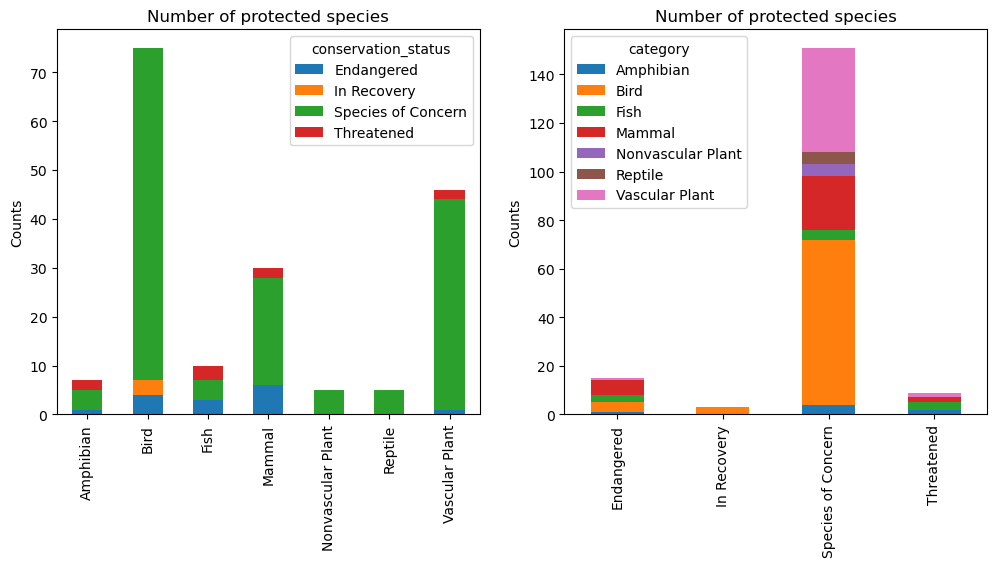

In [811]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
cons_category_pivot1.plot(ax=ax1, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Counts')
plt.title('Number of protected species')

ax2 = plt.subplot(1,2,2)
cons_category_pivot2.plot(ax=ax2, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Counts')
plt.title('Number of protected species')

plt.show()

We can see that the majority of protected species has the status "Species of concern", and birds are the majority of all protected species.

## Relationship betweeen  categories and  conservation statuses
Are some categories more likely to be endangered?

Since we're dealing with categorical variables, we can evaluate the relationship between them using contingency tables

In [812]:
species['is_protected'] = species.conservation_status != 'No concern'

In [813]:
species

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No concern,False
1,Mammal,Bos bison,"American Bison, Bison",No concern,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No concern,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No concern,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True
...,...,...,...,...,...
3228,Bird,Vireo solitarius,"Blue-Headed Vireo,Blue-Headed Vireo, Solitary ...",No concern,False
2327,Vascular Plant,Vulpia bromoides,"Fescue,Brome Fescue, Brome Six-Weeks Grass, De...",No concern,False
2328,Vascular Plant,Vulpia myuros,"Rattail Fescue,Foxtail Fescue, Rattail Fescue,...",No concern,False
4286,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",No concern,False


In [814]:
protected_species = species.groupby(['category', 'is_protected']).count().reset_index()

In [815]:
protected_species

,category,is_protected,scientific_name,common_names,conservation_status
0,Amphibian,False,72,72,72
1,Amphibian,True,7,7,7
2,Bird,False,413,413,413
3,Bird,True,75,75,75
4,Fish,False,114,114,114
5,Fish,True,10,10,10
6,Mammal,False,146,146,146
7,Mammal,True,30,30,30
8,Nonvascular Plant,False,328,328,328
9,Nonvascular Plant,True,5,5,5


In [816]:
protected_species = protected_species.pivot(columns='is_protected', index='category', values='scientific_name')\
.reset_index()
protected_species = protected_species.rename(columns={False : 'not_protected', True : 'protected', })

In [817]:
protected_species['total'] = protected_species.not_protected + protected_species.protected

In [818]:
protected_species['percent_protected'] = protected_species.protected / protected_species.total * 100

In [819]:
protected_species

is_protected,category,not_protected,protected,total,percent_protected
0,Amphibian,72,7,79,8.860759
1,Bird,413,75,488,15.368852
2,Fish,114,10,124,8.064516
3,Mammal,146,30,176,17.045455
4,Nonvascular Plant,328,5,333,1.501502
5,Reptile,73,5,78,6.410256
6,Vascular Plant,4216,46,4262,1.079305


Text(0.5, 1.0, 'Percent of protected apecies for each category')

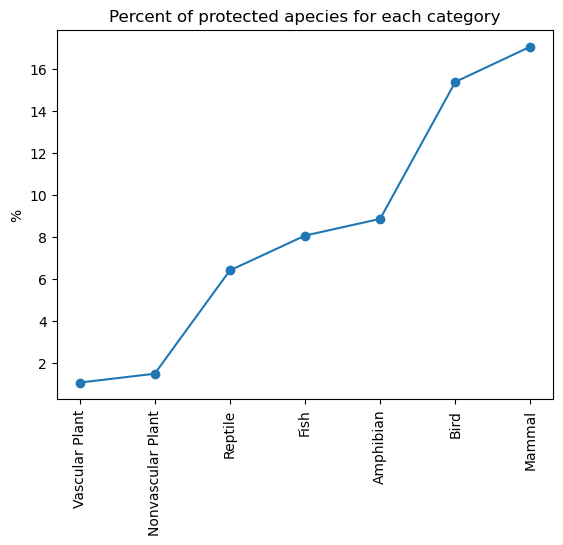

In [820]:
plt.plot(protected_species.sort_values('percent_protected').category, 
         protected_species.sort_values('percent_protected').percent_protected, marker='o')
plt.xticks(rotation=90)
plt.ylabel('%')
plt.title('Percent of protected apecies for each category')

In [821]:
protected_species

is_protected,category,not_protected,protected,total,percent_protected
0,Amphibian,72,7,79,8.860759
1,Bird,413,75,488,15.368852
2,Fish,114,10,124,8.064516
3,Mammal,146,30,176,17.045455
4,Nonvascular Plant,328,5,333,1.501502
5,Reptile,73,5,78,6.410256
6,Vascular Plant,4216,46,4262,1.079305


#### Example
Let's investigate the relationship in case of Vascular and Nonvascular plants as an example:

H0: there is no difference in protection rate between 2 groups.

Ha: there is difference in protection rate between 2 groups.

In [822]:
#protected, not_protected

contingency = [[5, 328],
              [46, 4216]]

total = 5 + 328 + 46 + 4216

contingency_prop = [[5 / total, 328 / total ],
                    [46 / total, 4216 / total]] 

contingency_prop

[[0.001088139281828074, 0.07138193688792166],
 [0.01001088139281828, 0.917519042437432]]

In [823]:
# marginal proportions:
# status: protected: 0.00108 + 0.0100 = 0.01108
# status: not_protected: 0.071 + 0.917 = 0.988
# category: nonvascular: 0.0713 + 0.00108 = 0.07238
# category: vascular: 0.9175 + 0.0100 = 0.9275

In [824]:
# expected contigency table
#.   0.01108 * 0.07238 = 0.00080;  0.988 * 0.07238 = 0.071
#.   0.01108 * 0.9275 = 0.010;   0.988 * 0.9275 = 0.916

# * total
# 4   326     # very similar to observed contingency table
# 46  4209

In [825]:
chi2, pval, dof, expected = chi2_contingency(contingency)
print(chi2)
print(pval)
print(np.round(expected)) # same as we have calculated

0.19069121233812064
0.6623419491381985
[[4.000e+00 3.290e+02]
 [4.700e+01 4.215e+03]]


pval=0.69 is much higher than the standard threshold of 0.05, chi2 is relatively small and expected contingency able look similar to observed one. Thus, we can state that in case of vascular and nonvascular plants there is no relationship between protection status and category, so there is no statistically significant difference betweeen  percent_protected of these 2 groups of plants (we accept H0).


Let's investigate relationship in case of  mammals and fish 

H0: there is no difference in protection rate between 2 groups.

Ha: there is difference in protection rate between 2 groups.

In [826]:
protected_species

is_protected,category,not_protected,protected,total,percent_protected
0,Amphibian,72,7,79,8.860759
1,Bird,413,75,488,15.368852
2,Fish,114,10,124,8.064516
3,Mammal,146,30,176,17.045455
4,Nonvascular Plant,328,5,333,1.501502
5,Reptile,73,5,78,6.410256
6,Vascular Plant,4216,46,4262,1.079305


In [827]:
contingency2 = [[30, 146],
              [10, 114]]

In [828]:
chi2, pval, dof, expected = chi2_contingency(contingency2)
print(chi2)
print(pval)
print(np.round(expected)) 

4.33022748420934
0.03744124155526616
[[ 23. 153.]
 [ 17. 107.]]


pval=0.037 is slightly lower than the standard threshold of 0.05. Thus, the difference between  mammals and  fish is statistically significant, and  mammals have statistically significant higher rate of percent_protected than  fish. In other words,  mammals tend to be more endangered than  fish (we reject H0).

## Species in different parks

In [829]:
species.head(5)

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No concern,False
1,Mammal,Bos bison,"American Bison, Bison",No concern,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No concern,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No concern,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True


In [830]:
observations.head(5)

,scientific_name,park_name,observations
0,Abies bifolia,Bryce National Park,109
1,Abies bifolia,Great Smoky Mountains National Park,72
2,Abies bifolia,Yellowstone National Park,215
3,Abies bifolia,Yosemite National Park,136
4,Abies concolor,Bryce National Park,83


In [831]:
data_merged = species[['category', 'scientific_name']].merge(observations, on='scientific_name')

data_merged_pivot1 = data_merged.groupby(['park_name', 'category']).sum().reset_index()\
.pivot(columns='category', index='park_name', values = 'observations')

data_merged_pivot2 = data_merged.groupby(['park_name', 'category']).sum().reset_index()\
.pivot(columns='park_name', index='category', values = 'observations')

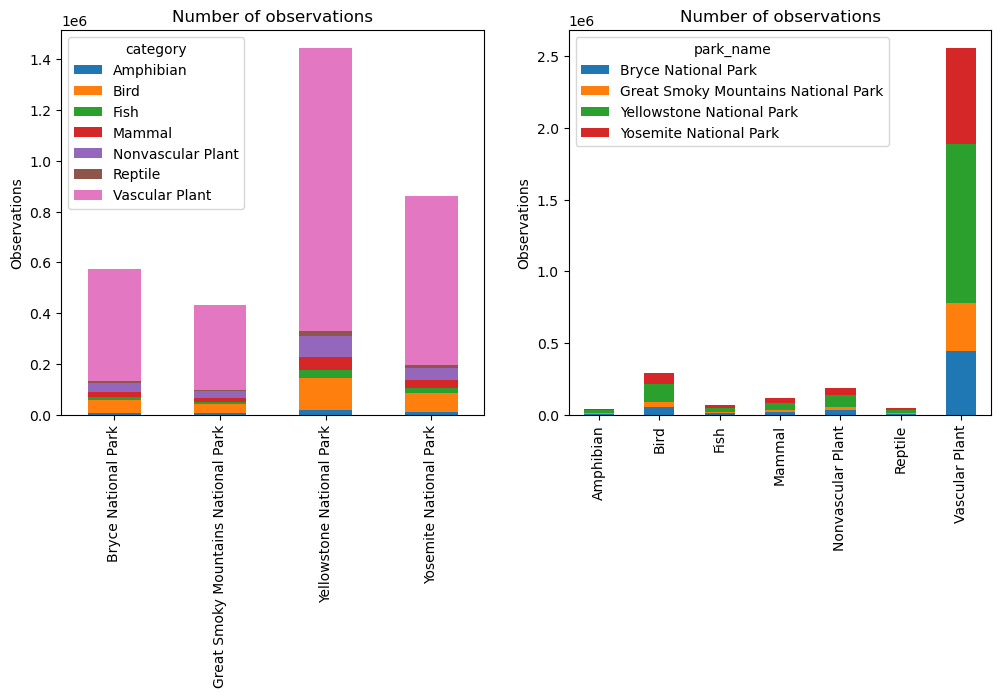

In [991]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
data_merged_pivot1.plot(ax=ax1, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Number of observations')

ax2 = plt.subplot(1,2,2)
data_merged_pivot2.plot(ax=ax2, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Observations')
plt.title('Number of observations')
plt.show()

Since there are far more Vascular Plants than other species, let's remove them from our visualisation

In [833]:
data_merged1 = data_merged[data_merged.category != 'Vascular Plant']

data_merged_pivot3 = data_merged1.groupby(['park_name', 'category']).sum().reset_index()\
.pivot(columns='category', index='park_name', values = 'observations')

data_merged_pivot4 = data_merged1.groupby(['park_name', 'category']).sum().reset_index()\
.pivot(columns='park_name', index='category', values = 'observations')

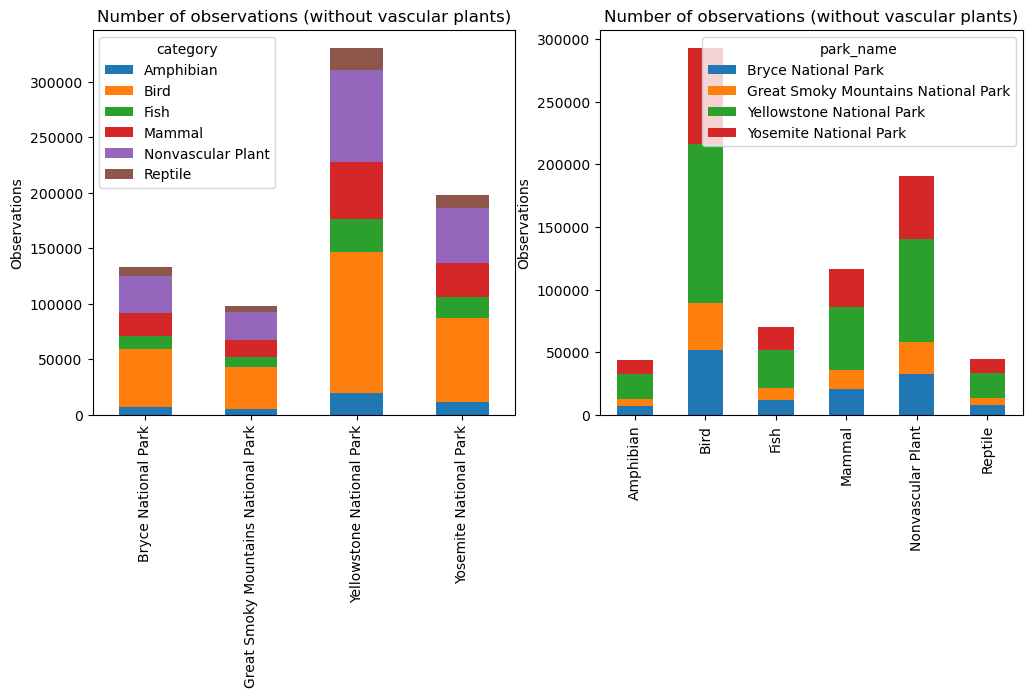

In [990]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
data_merged_pivot3.plot(ax=ax1, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Number of observations (without vascular plants)')

ax2 = plt.subplot(1,2,2)
data_merged_pivot4.plot(ax=ax2, kind='bar', stacked=True)
plt.xlabel('')
plt.ylabel('Number of Observations')
plt.title('Number of observations (without vascular plants)')
plt.show() 

Both with and without plants, the Yellowstone National Park  seems to be the most popular one to observe different species.

### Investigation of different 'classes' of species 

In [946]:
species

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No concern,False
1,Mammal,Bos bison,"American Bison, Bison",No concern,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No concern,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No concern,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True
...,...,...,...,...,...
3228,Bird,Vireo solitarius,"Blue-Headed Vireo,Blue-Headed Vireo, Solitary ...",No concern,False
2327,Vascular Plant,Vulpia bromoides,"Fescue,Brome Fescue, Brome Six-Weeks Grass, De...",No concern,False
2328,Vascular Plant,Vulpia myuros,"Rattail Fescue,Foxtail Fescue, Rattail Fescue,...",No concern,False
4286,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",No concern,False


In [947]:
species1 = species.copy()

We will try to combine some species of the same class (e.g. Vulpes fulva (Silver fox) and Vulpes vulpes (Red fox) are different species, but they are both foxes) and investigate how many species of 1 class were observed in parks.

We will also exclude plants from this dataset, since there are too many of them compared to other categories. 

In [948]:
species1 = species1[species1.category != 'Vascular Plant']
species1 = species1[species1.category != 'Nonvascular Plant']
species1.common_names = species1.common_names.str.lower()

In [949]:
species1.head(10)

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,gapper's red-backed vole,No concern,False
1,Mammal,Bos bison,"american bison, bison",No concern,False
2,Mammal,Bos taurus,"aurochs, aurochs, domestic cattle (feral), dom...",No concern,False
3,Mammal,Ovis aries,"domestic sheep, mouflon, red sheep, sheep (feral)",No concern,False
7,Mammal,Canis latrans,coyote,Species of Concern,True
8,Mammal,Canis rufus,red wolf,Endangered,True
10,Mammal,Vulpes fulva,"black fox, cross fox, red fox, silver fox",No concern,False
11,Mammal,Vulpes vulpes,red fox,No concern,False
12,Mammal,Felis concolor,mountain lion,No concern,False
13,Mammal,Felis silvestris,"wild cat, wildcat",No concern,False


In order to do this, we'll calculate occurencies of different words in common_names

In [950]:
def common_name(string):
    '''
    This function turn the string into a list of unique words of this string.
    '''
    a = []
    if ',' in string:
        a = string.split(',')
    else:
        a.append(string)

    result = []
    for i in range(len(a)):
        if a[i][0] == ' ':
            a[i] = a[i][1:]
            
        if '(' in a[i]:
            a[i] = a[i].replace('(', '')
            
        if ')' in a[i]:
            a[i] = a[i].replace(')', '')
        
        if ' ' in a[i]:
            b = a[i].split(' ')
            result += b
        else:
            result.append(a[i])   
    return list(set(result))

In [951]:
species1.common_names = species1.common_names.apply(common_name)

In [952]:
species1.head(5)

,category,scientific_name,common_names,conservation_status,is_protected
0,Mammal,Clethrionomys gapperi gapperi,"[vole, gapper's, red-backed]",No concern,False
1,Mammal,Bos bison,"[bison, american]",No concern,False
2,Mammal,Bos taurus,"[cattle, domestic, domesticated, aurochs, feral]",No concern,False
3,Mammal,Ovis aries,"[sheep, domestic, mouflon, red, feral]",No concern,False
7,Mammal,Canis latrans,[coyote],Species of Concern,True


We have to calculate occurency of different words in common_names:

In [953]:
names = list(species1.common_names) # list of lists

names_1list = []  # to 1 list
for i in names:
    names_1list += i
    
    
words_occurencies = dict()   # calculation of occurencies of each word in the list
for i in names_1list:
    if i in words_occurencies.keys():
        words_occurencies[i] += 1 
    else:
        words_occurencies[i] =1

In [954]:
words_occurencies = dict(sorted(words_occurencies.items(), key=lambda item: -item[1]))

In [955]:
i = 1
for key, value in words_occurencies.items():
    print("{0}: {1}".format(key,value))
    i += 1
    if i == 20:
        break

warbler: 59
northern: 50
salamander: 41
eastern: 38
american: 35
western: 30
common: 28
sparrow: 28
snake: 28
mountain: 21
shiner: 20
darter: 19
bat: 18
flycatcher: 17
california: 17
red: 16
black: 16
mouse: 15
owl: 15


We can state that among birds 28 species of sparrows were observed (since we removed all duplicates before), which makes it the most popular class of birds in this dataset.

Let's focus on owls.

In [956]:
species1['is_owl'] = species1.common_names.apply(lambda x: True if 'owl' in x else False)

In [957]:
owls = species1[species1.is_owl]

In [958]:
owls

,category,scientific_name,common_names,conservation_status,is_protected,is_owl
350,Bird,Aegolius acadicus,"[saw-whet, northern, owl]",No concern,False,True
351,Bird,Asio flammeus,"[owl, short-eared]",Species of Concern,True,True
352,Bird,Asio otus,"[long-eared, owl]",Species of Concern,True,True
353,Bird,Bubo virginianus,"[horned, owl, great]",No concern,False,True
356,Bird,Strix varia,"[owl, barred]",No concern,False,True
3244,Bird,Psiloscops flammeolus,"[owl, flammulated]",No concern,False,True
3245,Bird,Aegolius funereus,"[owl, boreal]",No concern,False,True
3246,Bird,Athene cunicularia,"[owl, burrowing]",No concern,False,True
3247,Bird,Bubo scandiacus,"[owl, snowy]",No concern,False,True
4568,Bird,Otus flammeolus,"[owl, flammulated]",No concern,False,True


In [959]:
owls_obs = observations.merge(owls, on='scientific_name')

In [960]:
owls_obs

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_owl
0,Aegolius acadicus,Bryce National Park,131,Bird,"[saw-whet, northern, owl]",No concern,False,True
1,Aegolius acadicus,Great Smoky Mountains National Park,86,Bird,"[saw-whet, northern, owl]",No concern,False,True
2,Aegolius acadicus,Yellowstone National Park,234,Bird,"[saw-whet, northern, owl]",No concern,False,True
3,Aegolius acadicus,Yosemite National Park,91,Bird,"[saw-whet, northern, owl]",No concern,False,True
4,Aegolius funereus,Bryce National Park,73,Bird,"[owl, boreal]",No concern,False,True
5,Aegolius funereus,Great Smoky Mountains National Park,82,Bird,"[owl, boreal]",No concern,False,True
6,Aegolius funereus,Yellowstone National Park,260,Bird,"[owl, boreal]",No concern,False,True
7,Aegolius funereus,Yosemite National Park,167,Bird,"[owl, boreal]",No concern,False,True
8,Asio flammeus,Bryce National Park,82,Bird,"[owl, short-eared]",Species of Concern,True,True
9,Asio flammeus,Great Smoky Mountains National Park,45,Bird,"[owl, short-eared]",Species of Concern,True,True


In [983]:
owls_obs_grouped = owls_obs.groupby(['park_name', 'conservation_status']).observations.sum().reset_index()
owls_obs_grouped

,park_name,conservation_status,observations
0,Bryce National Park,No concern,1777
1,Bryce National Park,Species of Concern,176
2,Great Smoky Mountains National Park,No concern,1293
3,Great Smoky Mountains National Park,Species of Concern,101
4,Yellowstone National Park,No concern,4233
5,Yellowstone National Park,Species of Concern,478
6,Yosemite National Park,No concern,2387
7,Yosemite National Park,Species of Concern,256


Text(0.5, 0, '')

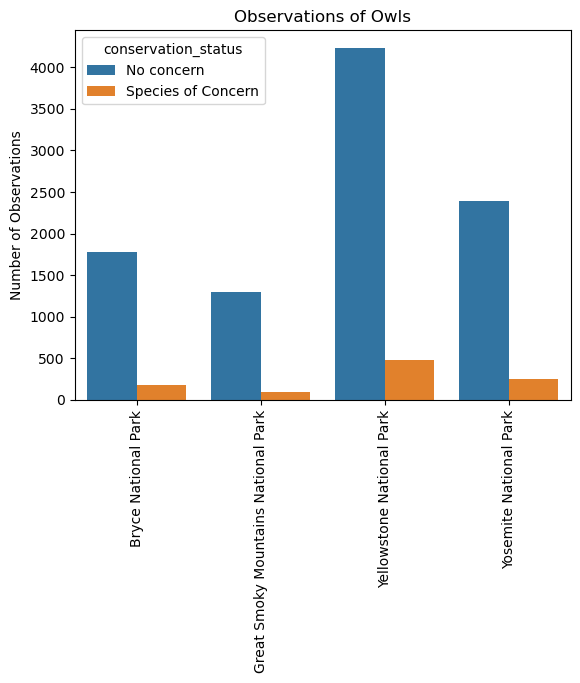

In [995]:
sns.barplot(data=owls_obs_grouped, x='park_name', y='observations', hue='conservation_status')
plt.xticks(rotation=90)
plt.title('Observations of Owls')
plt.ylabel('Number of Observations')
plt.xlabel('')

# Conclusion

- The majority of species in this dataset is not protected
- In the Yellowstone National Park most observations were made
- Fish and mammals protected rates show statistically significant difference, while there is no statistically significant difference in case of vascular and nonvascular plants 
- Mammals have the highest rate of protected species
- 15 species of owls were observed, and they were most likely to appear in the Yellowstone National Park